In [132]:
from load_data import *
from helpers import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold
import xgboost
import shap
from sklearn.decomposition import PCA

In [133]:
wrangler = Wrangler()
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)

# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]

X_train, y_train = wrangler.fit_transform_dendro(listings)

------------------------------
Fit and Transform data...
------------------------------
58 amenities have been removed due to close zero-variance.
Text, OpenStreet and image data loaded.
61 binary variables have been removed due to close zero-variance.
Imputation done. No NaN's are left in the data.
Due to insignificant t-tests we drop:
['host_is_superhost', 'Extra pillows and blankets', 'Luggage dropoff allowed', 'Free_parking', 'host_name_sounds_west', 'host_name_sounds_rare', 'host_location_country_Ireland', 'neighbourhood_cleansed_Dn Laoghaire-Rathdown']


In [134]:
#X_train, X_test, X_val, y_train, y_test, y_val = load_data(for_dendro = True)

# Variable Selection

In [135]:
bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]

In [136]:
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]

In [137]:
len(X_train.columns) == len(num_col) + len(bin_col)

True

In [138]:
X_train

,host_identity_verified,instant_bookable,Bathtub,Bed_linens,Breakfast,Cable_TV,Carbon_monoxide_alarm,Cooking_basics,Dishes_and_silverware,Dishwasher,Elevator,Fire_extinguisher,First_aid_kit,Hair_dryer,Hangers,Host_greets_you,Hot_water,Indoor_fireplace,Iron,Lock_on_bedroom_door,Long_term_stays_allowed,Microwave,Private_entrance,Shower_gel,Smoke_alarm,Oven_available,Stoves_available,Refridgerator_available,Garden_backyard_available,Paid_parking,Workspace,Shampoo_Conditioner_available,Coffee_machine_available,Dryer_available,Washer_available,Patio_balcony_available,Kitchen_available,Safe_available,TV_available,Baby_friendly,in_city,sex_amenities,kiosks,bath_number_1,bath_number_2,bedrooms_1,bedrooms_2,neighbourhood_cleansed_Dublin_City,property_type_Entire_rental_unit,property_type_Entire_residential_home,property_type_Private_room_in_rental_unit,property_type_Private_room_in_residential_home,room_type_Entire_home/apt,room_type_Private_room,bath_kind_Normal,bath_kind_Private,bath_kind_Shared,host_since,host_listings_count,latitude,longitude,accommodates,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,name_length,description_length,neighborhood_overview_length,host_about_length,prop_of_eng_reviews,mean_compound,mean_negativity,mean_neutrality,mean_positivity,mean_review_length,prop_of_neg_comp,most_neg_compound,most_pos_compound,compound_descr,negativity_descr,neutrality_descr,positivity_descr,compound_neigh_over,negativity_neigh_over,neutrality_neigh_over,positivity_neigh_over,compound_host_ab,negativity_host_ab,neutrality_host_ab,positivity_host_ab,bars,cafes,fast_foods,restaurants,library,university,bus_train_tram_station,bicycle_rentals,parking,taxi,casinos,cinemas,nightclubs,social_amenities,theatres_artscentre,malls,supermarkets,nearest_sight,2nd_nearest_sight,3rd_nearest_sight,mean_dist_sight,nearest_travel_poss,mean_dist_travel,count,brightness,contrast,no_img_bathroom,no_img_bedroom,no_img_dining,no_img_hallway,no_img_kitchen,no_img_living,no_img_others
0,1,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,2.681929,-0.160081,-1.199921,-0.031328,-0.504124,0.190424,-0.136022,1.030457,-0.453591,-0.512201,0.238499,1.271655,3.256260,-0.252390,-0.247578,3.622701,-0.077984,0.308628,0.159223,0.178754,0.297317,-0.212508,0.455187,-0.150724,0.363238,-0.186395,-0.196345,0.838155,0.824458,-0.191790,0.828823,-0.379597,-0.076704,-0.095341,-0.132297,0.969948,0.681506,0.592170,-1.031656e-01,0.635124,-1.529212e-01,2.376571e-01,-2.487115e-01,0.868164,-2.818437e-01,-0.330541,4.037635e-01,0.676140,-0.567256,0.042740,0.092087,0.908472,2.602866,-0.795344,0.366180,1.465100,-0.161892,0.538839,1.749552,-0.720965,-0.723070,-0.644653,-0.602103,-0.515267,-0.733735,-0.980638,-0.905498,0.098675,-0.789356,-0.61047,-0.780973,-0.564477,-1.531782,-0.704373,0.583010,-0.392278,0.464219,0.343740,0.291830,0.322248,0.841973,0.725965,2.215512,0.407620,-0.360136,-0.365663,1.554962,-0.531317,3.342654,0.557626,0.478369,3.188349
1,1,0,0,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,2.681929,-0.160081,-1.193016,-0.002611,-0.504124,-0.620285,-0.136022,-1.059240,-0.453591,-0.512201,0.201588,2.120229,2.509749,-0.252390,-0.247578,2.042047,-0.079539,0.333528,0.237918,0.178754,0.165699,-0.212508,0.405500,-0.150724,0.497997,-0.186395,-0.196345,-1.263408,-1.287226

# Correlation approach
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

We should take the correlation of the variables into account. Therefore we need different approaches dependent on the scale of variables
- pearson: numeric and numeric 
- jaccard: binary and binary
- point-biserial: binary and numeric

In [139]:
X_train.columns.values

array(['host_identity_verified', 'instant_bookable', 'Bathtub',
       'Bed_linens', 'Breakfast', 'Cable_TV', 'Carbon_monoxide_alarm',
       'Cooking_basics', 'Dishes_and_silverware', 'Dishwasher',
       'Elevator', 'Fire_extinguisher', 'First_aid_kit', 'Hair_dryer',
       'Hangers', 'Host_greets_you', 'Hot_water', 'Indoor_fireplace',
       'Iron', 'Lock_on_bedroom_door', 'Long_term_stays_allowed',
       'Microwave', 'Private_entrance', 'Shower_gel', 'Smoke_alarm',
       'Oven_available', 'Stoves_available', 'Refridgerator_available',
       'Garden_backyard_available', 'Paid_parking', 'Workspace',
       'Shampoo_Conditioner_available', 'Coffee_machine_available',
       'Dryer_available', 'Washer_available', 'Patio_balcony_available',
       'Kitchen_available', 'Safe_available', 'TV_available',
       'Baby_friendly', 'in_city', 'sex_amenities', 'kiosks',
       'bath_number_1', 'bath_number_2', 'bedrooms_1', 'bedrooms_2',
       'neighbourhood_cleansed_Dublin_City',
       'p

## Pearson Correlation

In [140]:
numerical_df = X_train.filter(num_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = numerical_df.columns

sel.fit_transform(numerical_df)
num_col = sel.get_feature_names_out()
print(str(len(numerical_df.columns) - len(num_col)) + " variables have been removed")
numerical_df = numerical_df.filter(num_col)

0 variables have been removed


In [141]:
PEARSON = np.abs(numerical_df.corr())

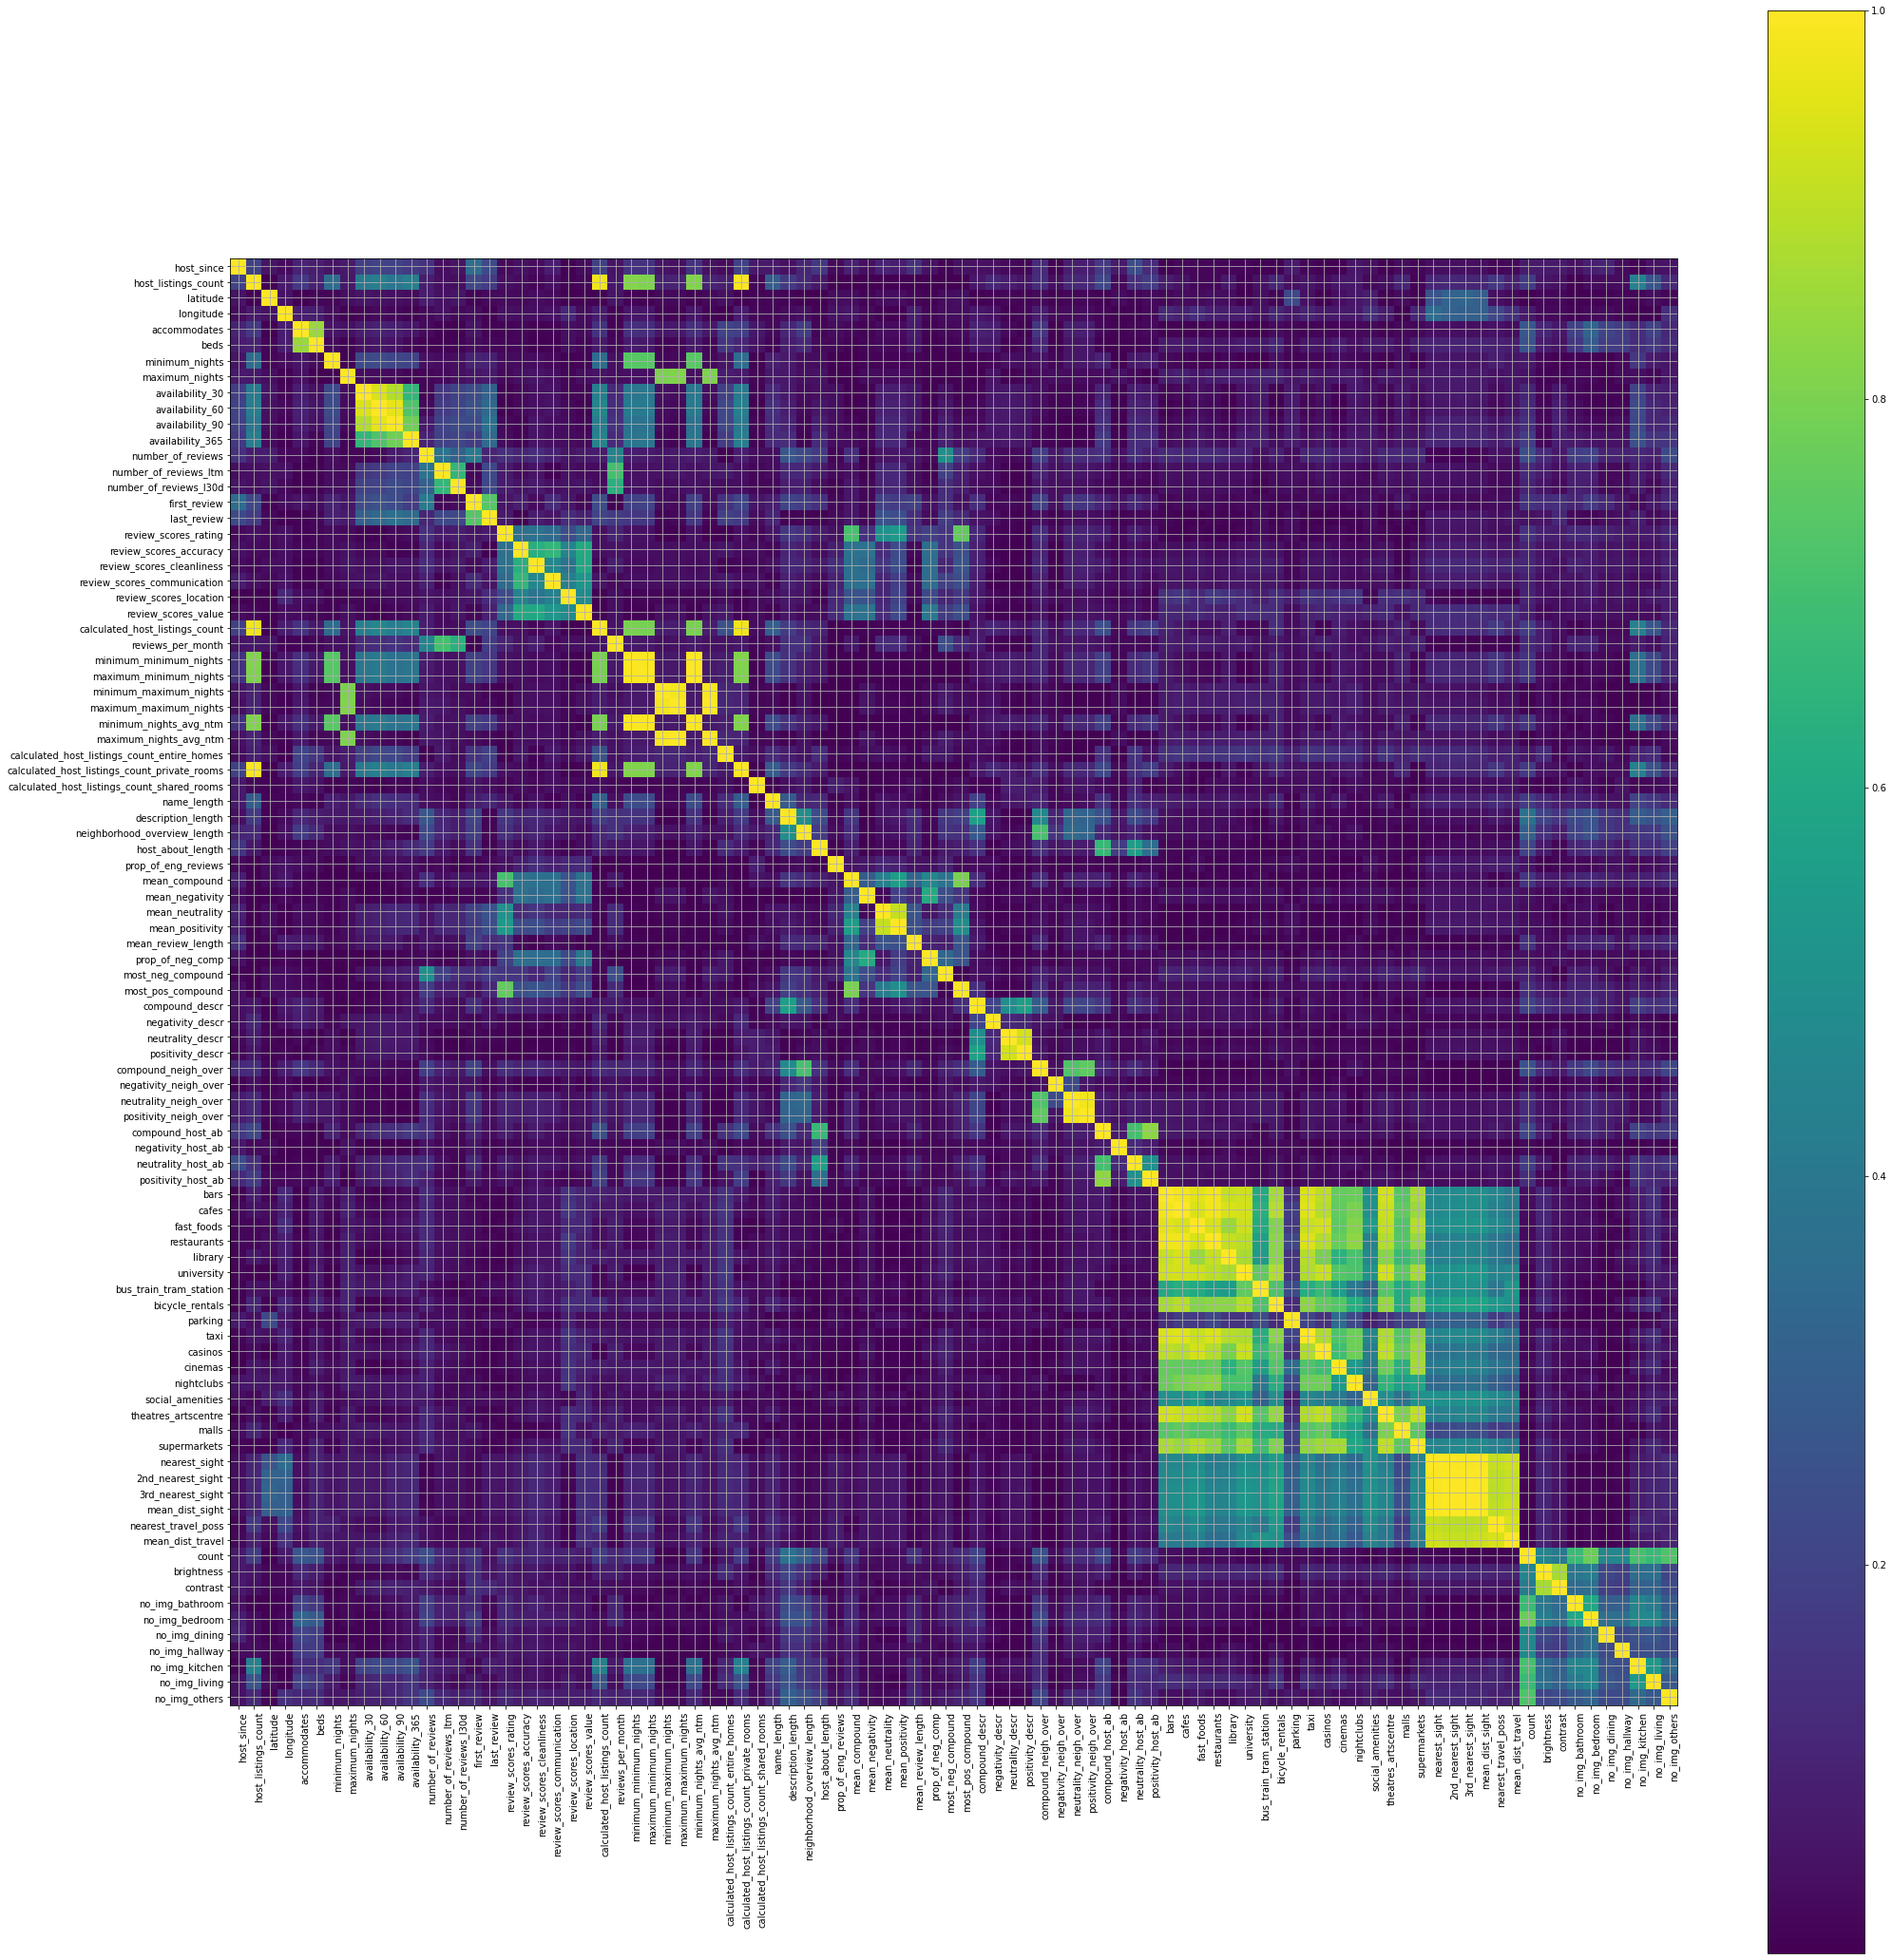

In [142]:
fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(np.abs(X_train.filter(num_col).corr()))
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(num_col)))
ax.set_xticklabels(labels=num_col)
ax.set_yticks(np.arange(len(num_col)))
ax.set_yticklabels(labels=num_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.tight_layout()
plt.show()

## Binary Features

Let's remove features which don't have enough variance or in other words which are either 0 or 1 in most of the cases 
- https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f







In [143]:
binary_df = X_train.filter(bin_col)

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
sel.feature_names_in_ = binary_df.columns

sel.fit_transform(binary_df)
binary_col = sel.get_feature_names_out()
print(str(len(binary_df.columns) - len(binary_col)) + " variables have been removed")
binary_df = binary_df.filter(binary_col)

0 variables have been removed


### Jaccard Correlation

At first lets define a function that calculates the Jaccard Correlation coefficient

In [144]:
def jac(x,y):
    a = ((x == 1) == (y == 1)).sum()
    b = ((x == 1) == (y == 0)).sum()
    c = ((x == 0) == (y == 1)).sum()
    #d = ((x == 0) == (y == 0)).sum()

    j = a/(a+b+c)

    return j

Now calculate the coefficient for each combination of binary covariables

In [145]:
# init matrix
A = np.zeros((len(binary_col), len(binary_col)))

for i, a in enumerate(binary_col):
    for j, b in enumerate(binary_col):
        A[i,j] = jac(binary_df[a], binary_df[b])

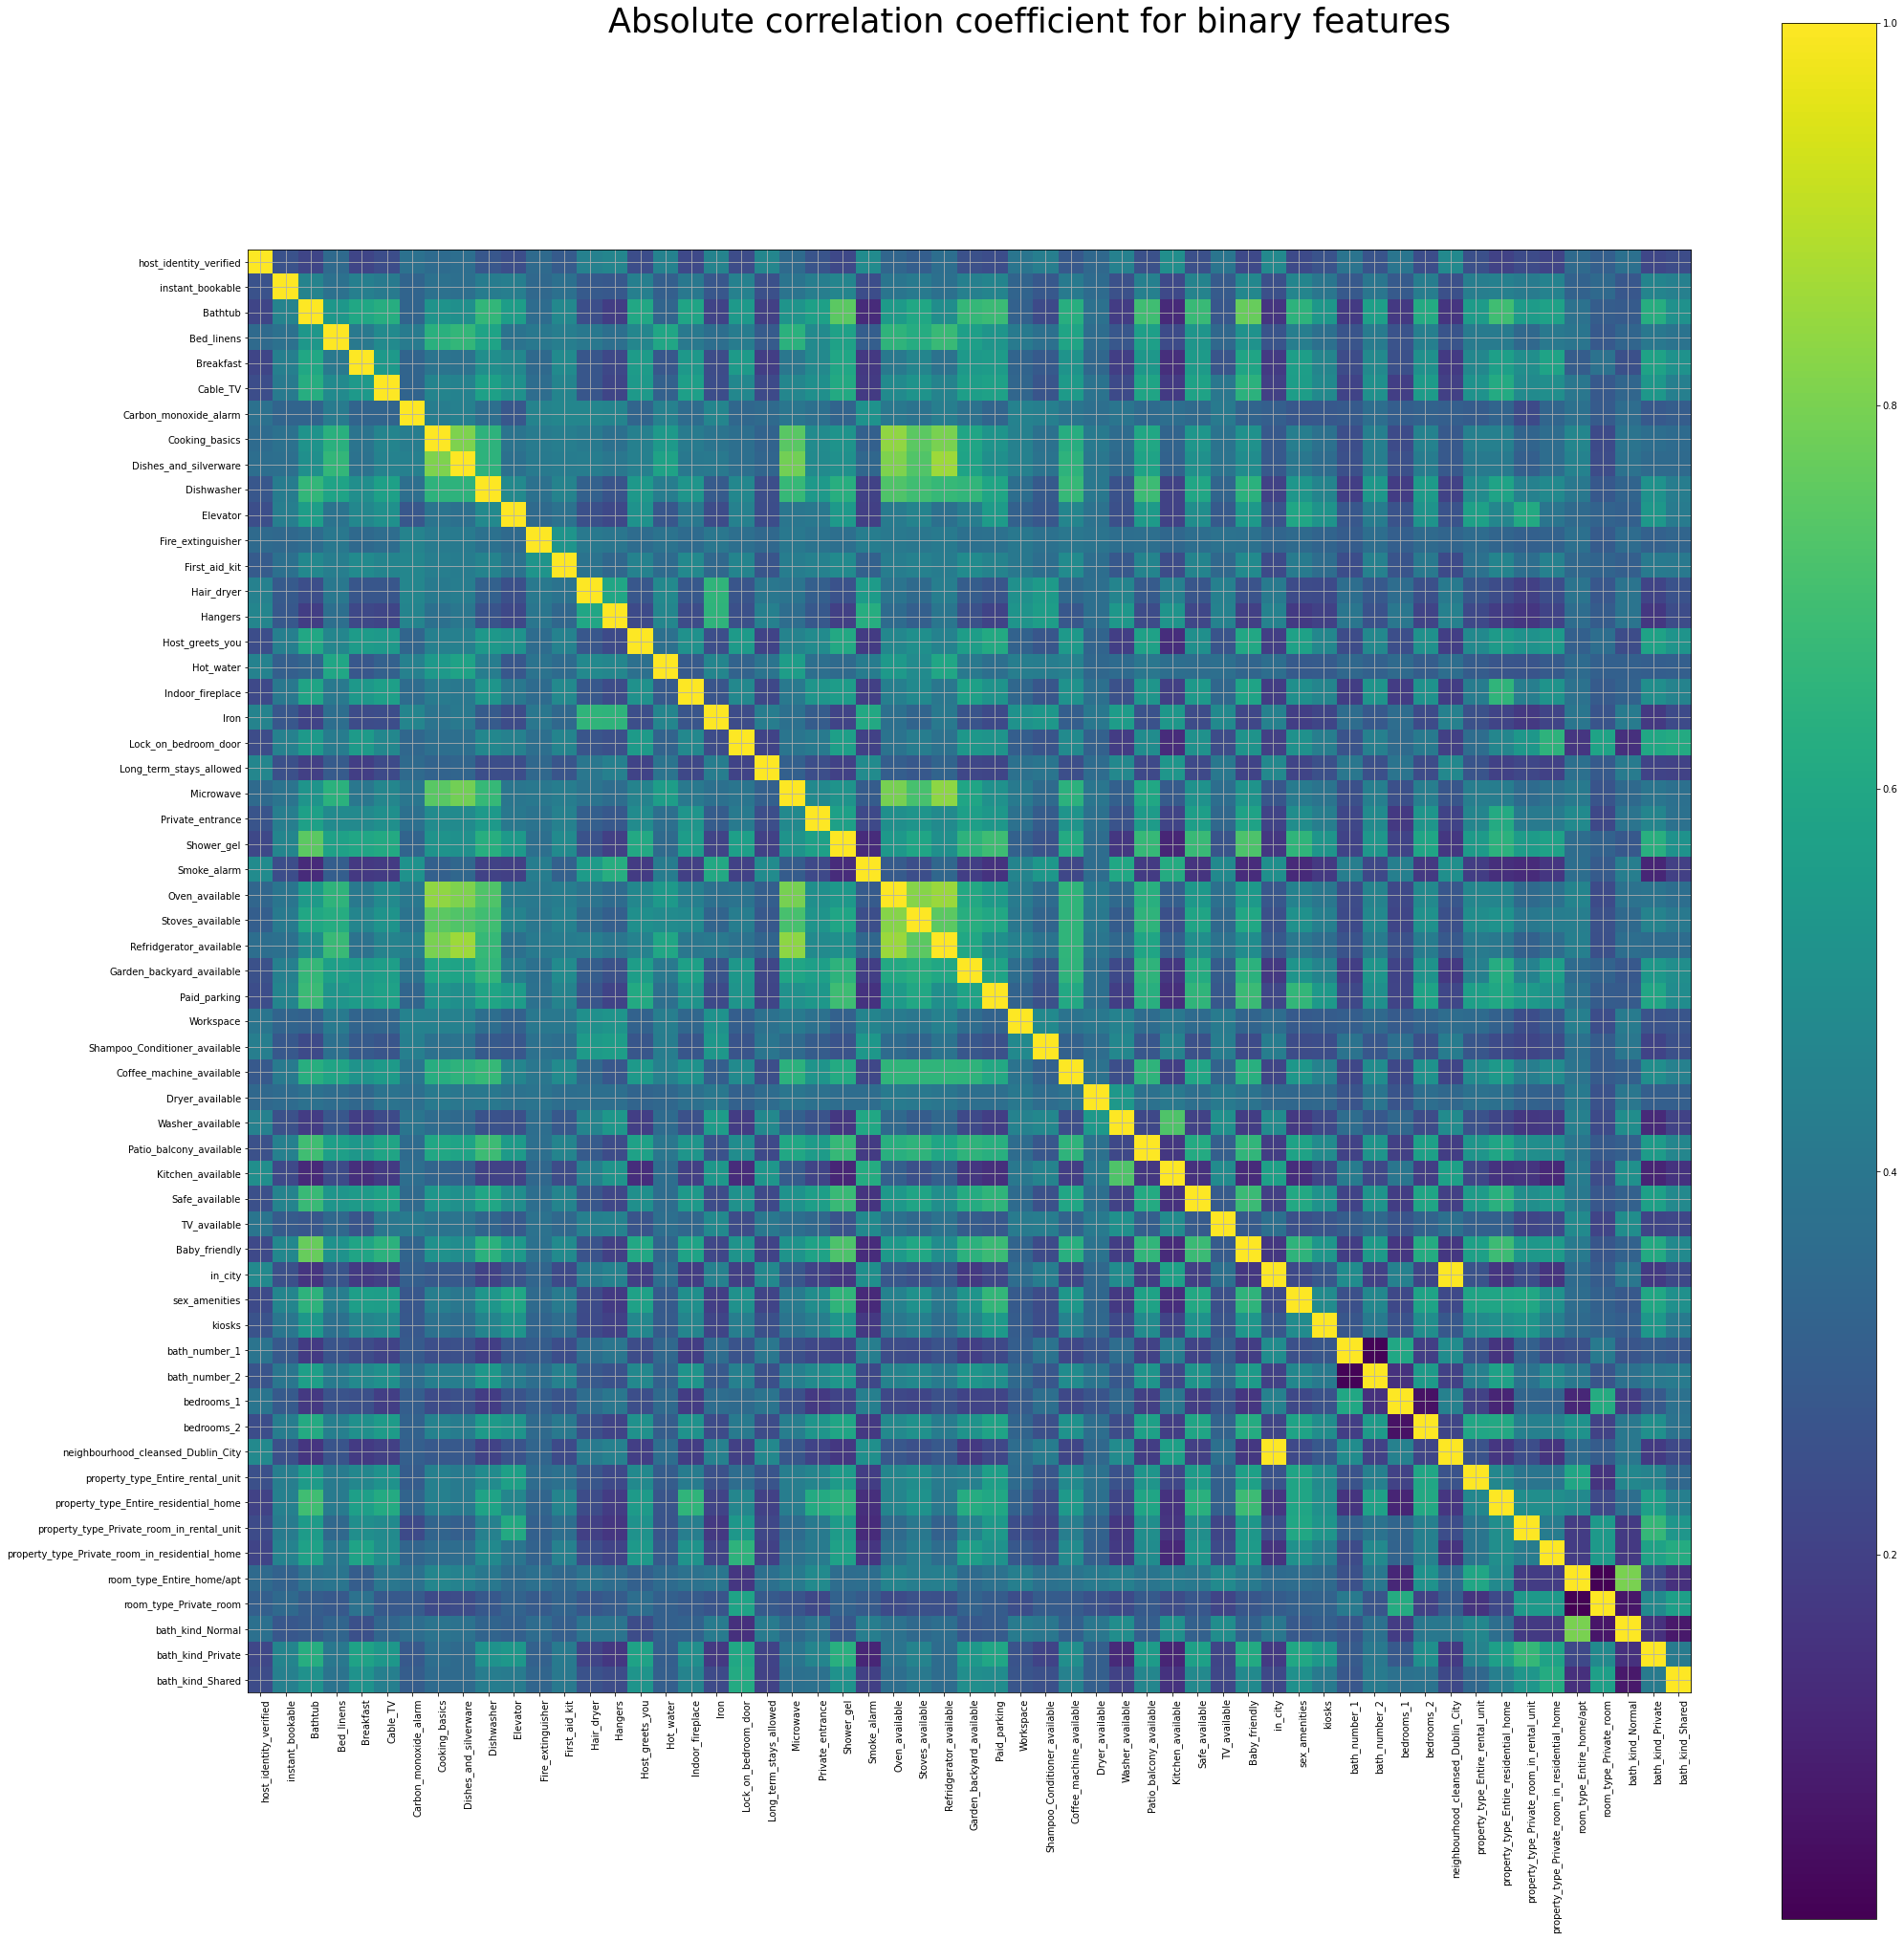

In [146]:
JACCARD = pd.DataFrame(np.abs(A))
jac_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(jac_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(binary_col)))
ax.set_xticklabels(labels = binary_col)
ax.set_yticks(np.arange(len(binary_col)))
ax.set_yticklabels(labels = binary_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary features", fontsize = 35)
fig.tight_layout()
plt.show()

## Point-Biserial

- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html

In [147]:
numerical_df.isna().sum()[numerical_df.isna().sum()>0]

Series([], dtype: int64)

In [148]:
binaries = binary_df
numericals = numerical_df

# init matrix
A = np.zeros((len(binaries.columns), len(numericals.columns)))
P = np.zeros((len(binaries.columns), len(numericals.columns)))

for i, a in enumerate(binaries.columns):
    for j, b in enumerate(numericals.columns):
        A[i,j], P[i,j] = stats.pointbiserialr(binaries[a], numericals[b])

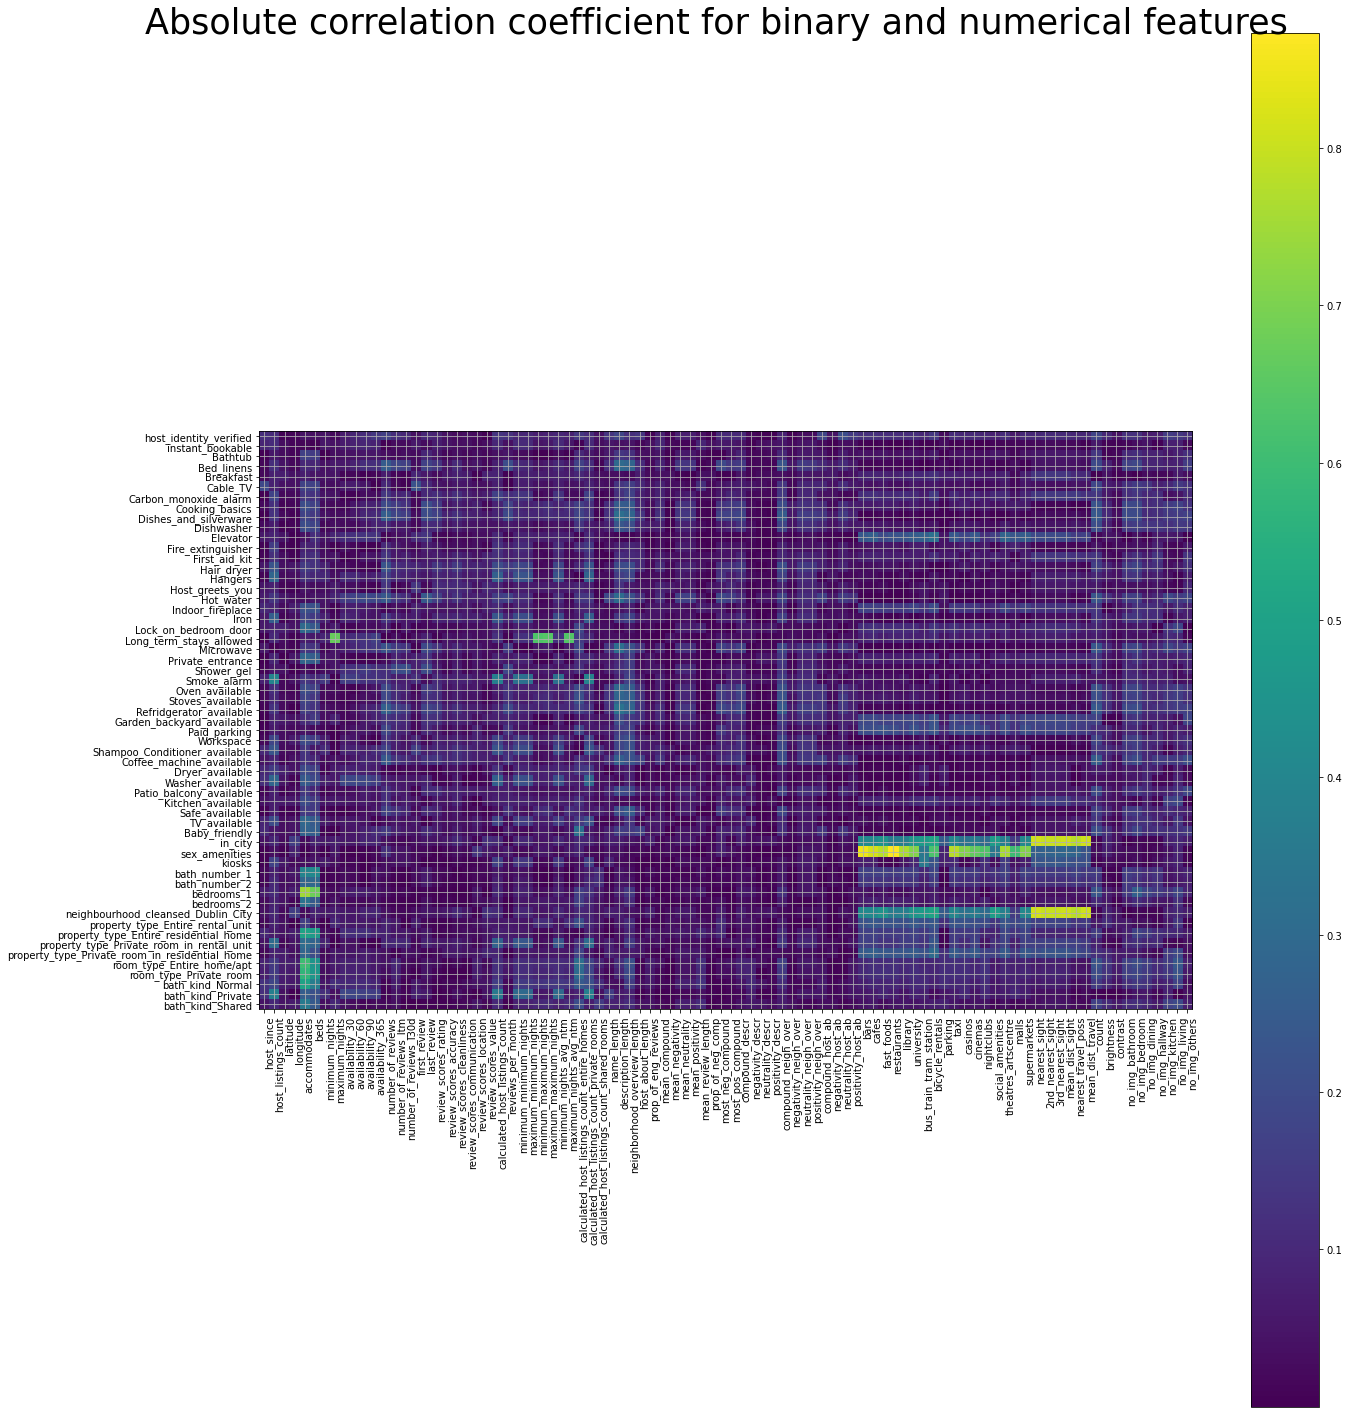

In [149]:
BISERIAL = pd.DataFrame(np.abs(A))
bis_df = pd.DataFrame(np.abs(A))

fig, ax = plt.subplots(figsize = (20,20))
im = ax.imshow(bis_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(numericals.columns)))
ax.set_xticklabels(labels=numericals)
ax.set_yticks(np.arange(len(binaries.columns)))
ax.set_yticklabels(labels=binaries)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

## Combine all correlation coefficients in a single matrix

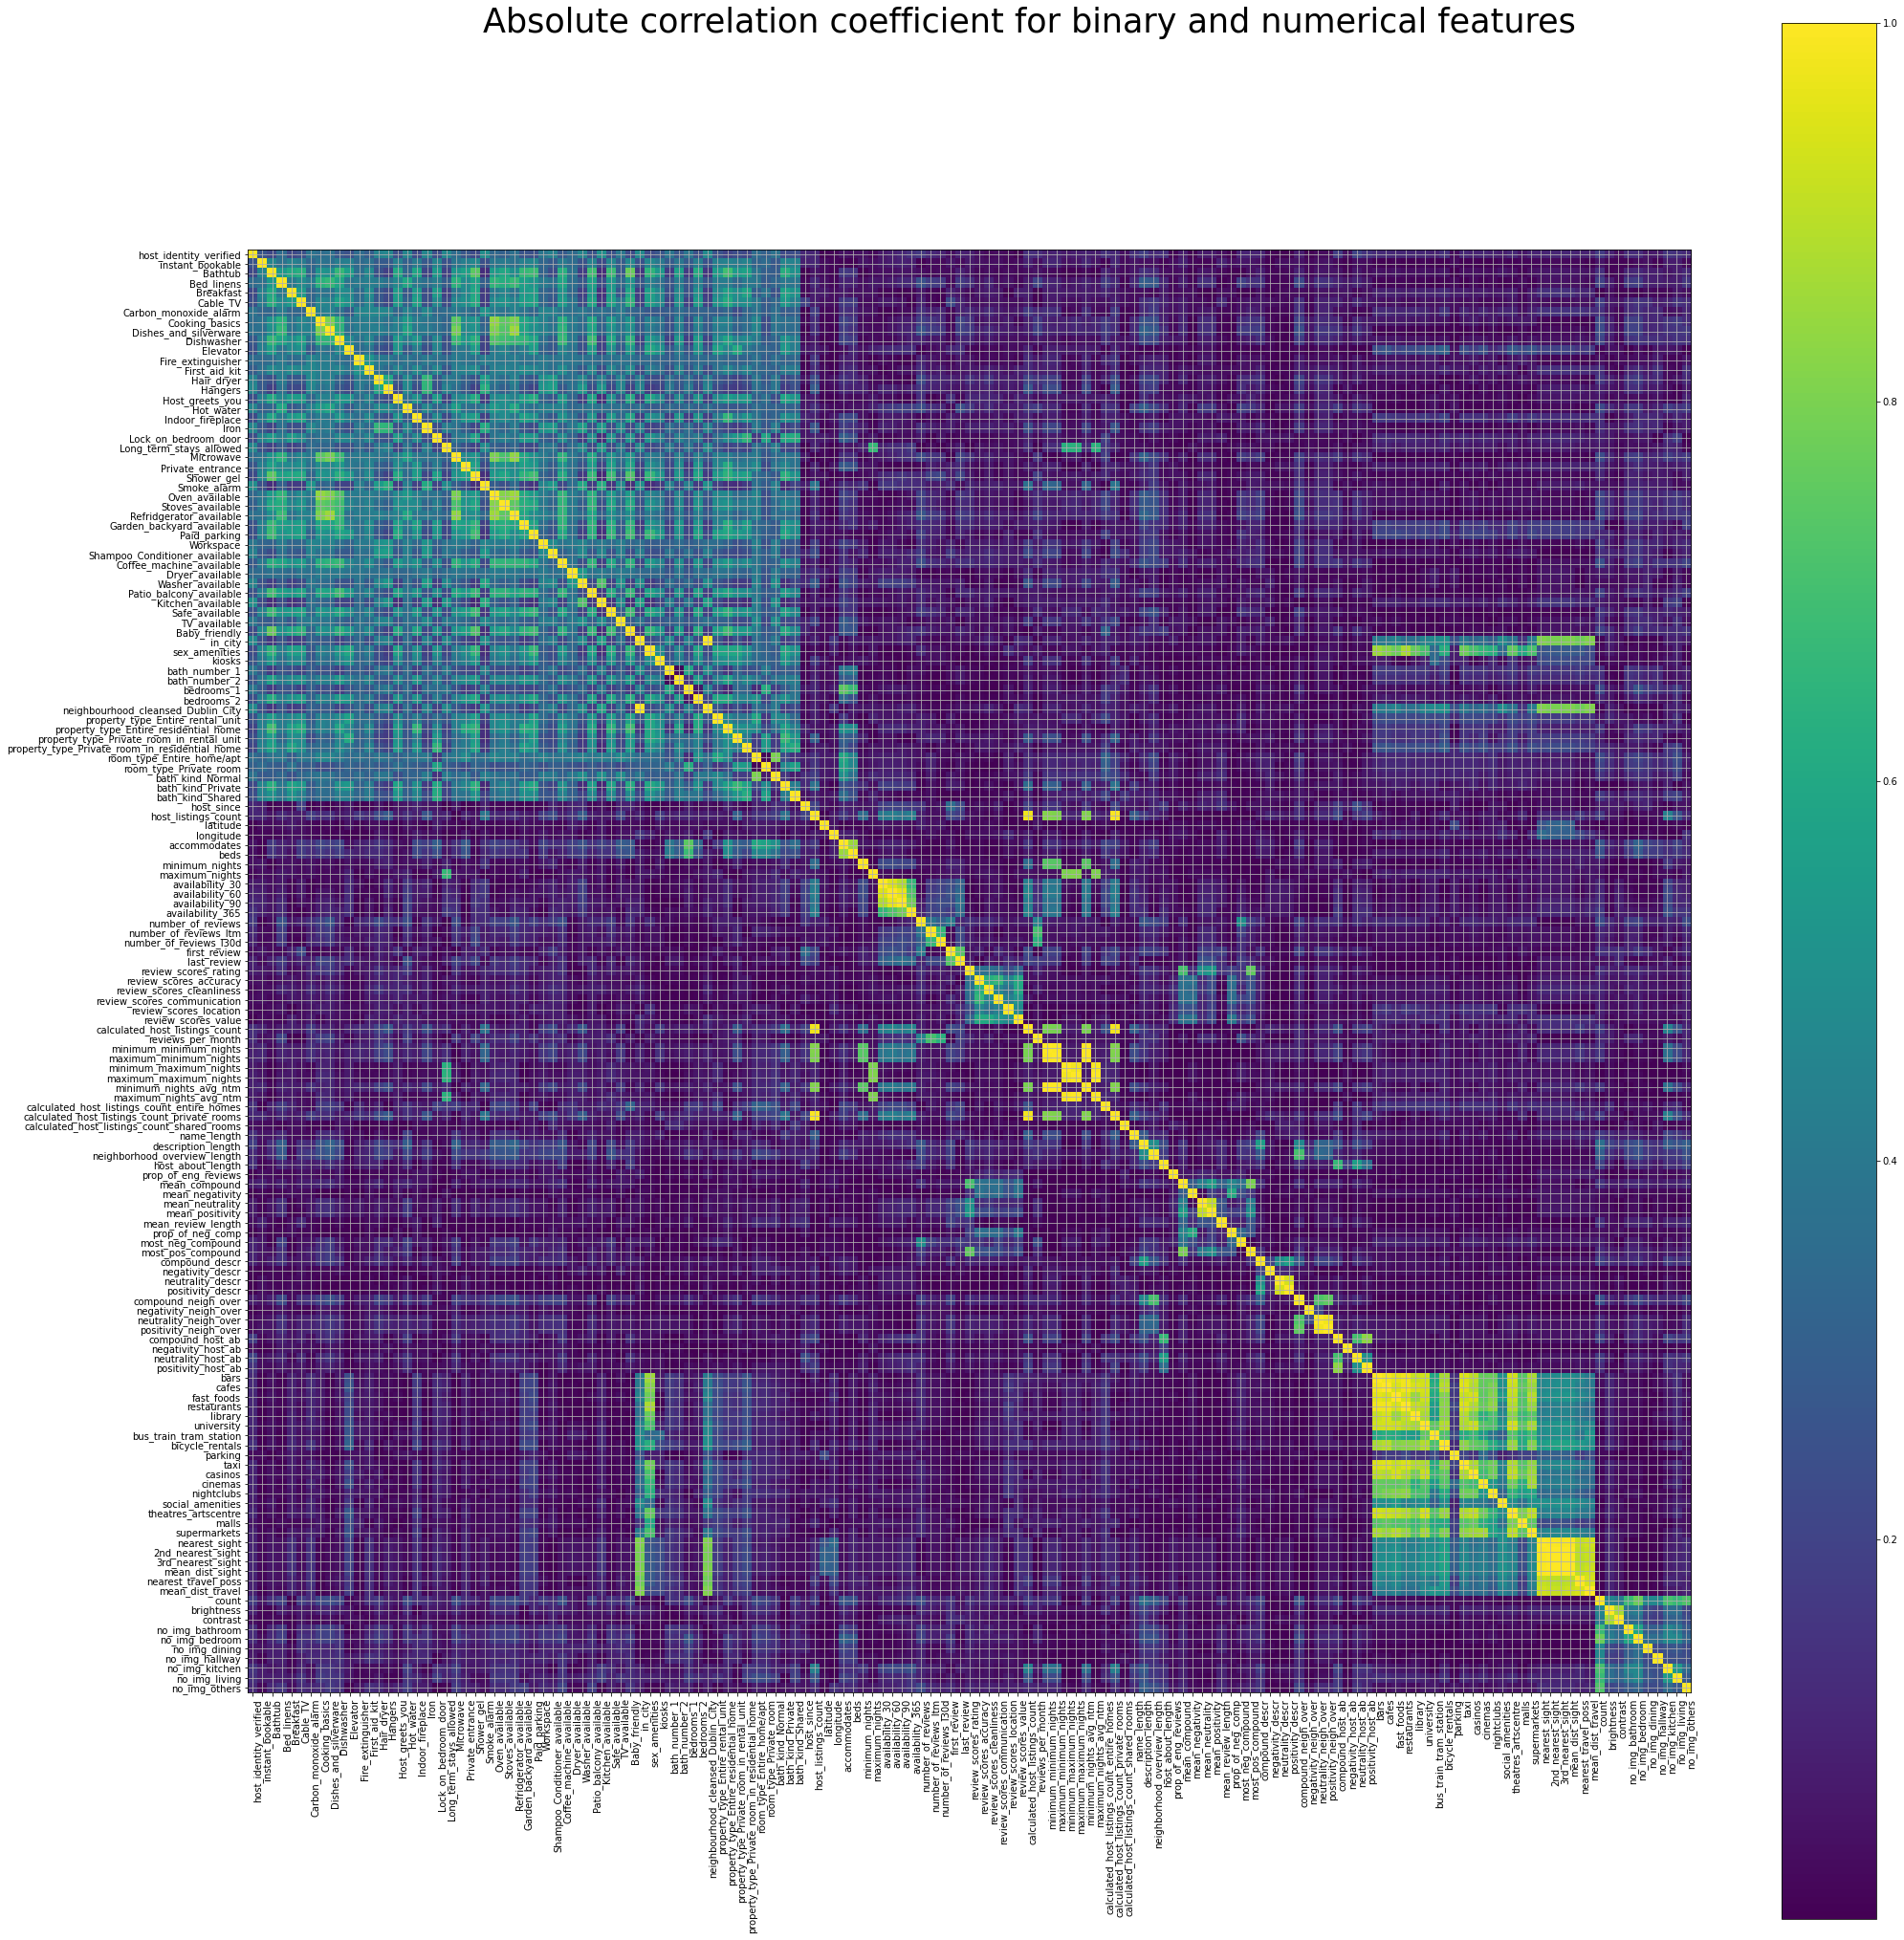

In [150]:
all_col = list(binary_col) + list(num_col)
X_train = X_train.filter(all_col)
C = np.zeros((len(all_col), len(all_col)))

C[:len(binary_col),:len(binary_col)] = JACCARD
C[len(binary_col):,len(binary_col):] = PEARSON
C[len(binary_col):,:len(binary_col)] = BISERIAL.T
C[:len(binary_col),len(binary_col):] = BISERIAL

C_df = pd.DataFrame(np.abs(C))

fig, ax = plt.subplots(figsize = (30,30))
im = ax.imshow(C_df)
ax.figure.colorbar(im)
ax.grid(None)
ax.set_xticks(np.arange(len(C_df.columns)))
ax.set_xticklabels(labels=all_col)
ax.set_yticks(np.arange(len(C_df.columns)))
ax.set_yticklabels(labels=all_col)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
fig.suptitle("Absolute correlation coefficient for binary and numerical features", fontsize = 35)
fig.tight_layout()
plt.show()

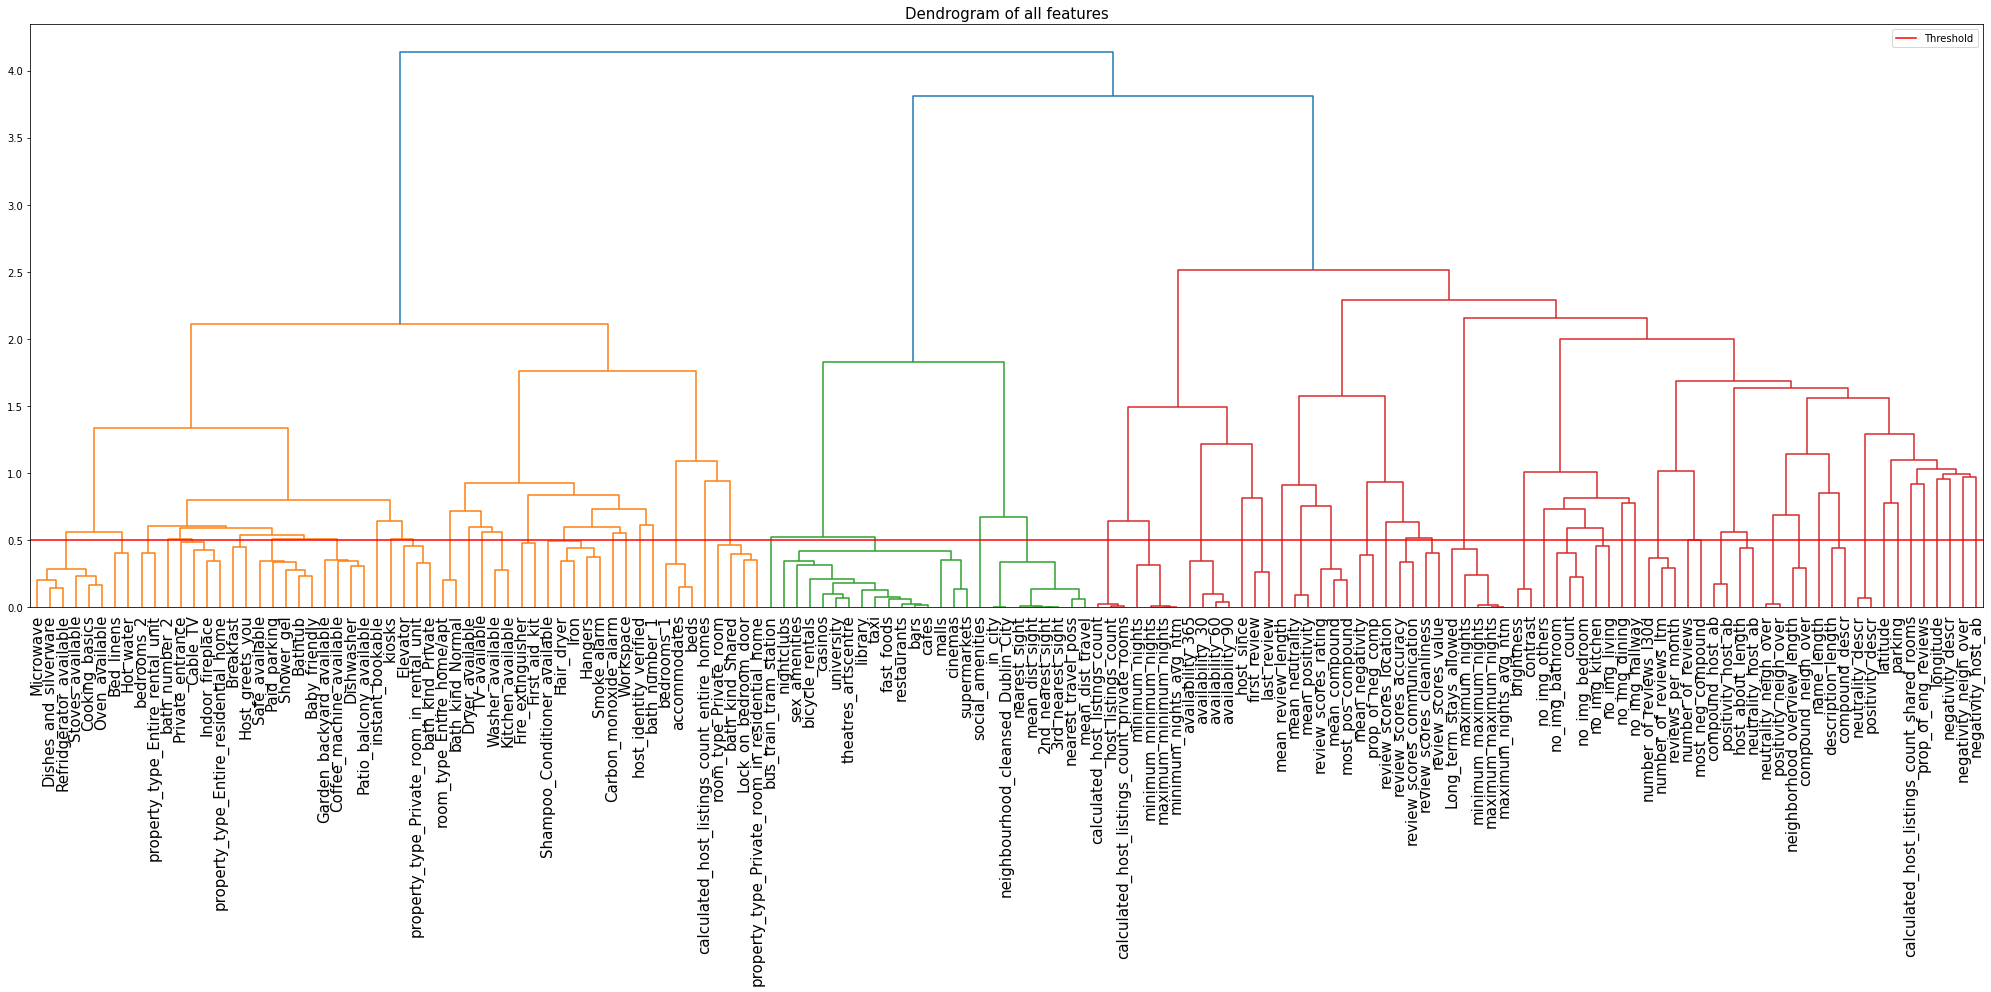

In [151]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr = C
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

The dendrogram shows which features are so similar that it might be reasonable to keep only one of those variables. We can set our threshold around 0.5 and explore the clusters.

First we use PCA´s for common topics; additionally we drop one variable if only two are correlated.

In [152]:
# PCA for city-life
city_life = ["nightclubs", "sex_amenities", "bicycle_rentals", "casinos", "university", "kiosks",
                 "theatres_artscentre", "library", "taxi", "fast_foods", "restaurants", "bars",
                 "cafes", "malls", "cinemas", "supermarkets", "bus_train_tram_station", "social_amenities"]
             
city_life_df = X_train[city_life]
city_life_pcas = PCA(n_components = 5).fit_transform(city_life_df)
X_train["city_life_pca1"] = city_life_pcas[:,0]
X_train["city_life_pca2"] = city_life_pcas[:,1]
X_train["city_life_pca3"] = city_life_pcas[:,2]
X_train["city_life_pca4"] = city_life_pcas[:,3]
X_train["city_life_pca5"] = city_life_pcas[:,4]
X_train = drop_col(X_train, city_life, regex = False)

# PCA for touristic and travel
travel_touristic = ["neighbourhood_cleansed_Dublin_City", "in_city", "nearest_sight", "mean_dist_sight", 
                    "2nd_nearest_sight", "3rd_nearest_sight", "nearest_travel_poss", "mean_dist_travel"]

travel_touristic_df = X_train[travel_touristic]

X_train["travel_touristic_pca"] = PCA(n_components = 1).fit_transform(travel_touristic_df)
X_train = drop_col(X_train, travel_touristic, regex = False)

In [153]:
X_train = drop_col(X_train, ["Washer_available"], regex = False) # keep Dryer available
X_train = drop_col(X_train, ["Hangers", "Hair_dryer", "Iron"], regex = False) # keep smoke_alarm
X_train = drop_col(X_train, ["Smoke_alarm"], regex = False) # keep Washer available
X_train = drop_col(X_train, ["First_aid_kit"], regex = False) # keep fire extinguisher
X_train = drop_col(X_train, ["Paid_parking", "Shower_gel", "Bathtub", "Baby_friendly",], regex = False) # keep Safe_available
X_train = drop_col(X_train, ["Coffee_machine_available", "Patio_balcony_available"], regex = False) #Dishwasher in KitchenPCA, keep garden_available
X_train = drop_col(X_train, ["Host_greets_you"], regex = False) # keep Breakfast, bath private in bath PCA
X_train = drop_col(X_train, ["first_review"], regex = False) # keep last_review
X_train = drop_col(X_train, ["review_scores_accuracy", "review_scores_accuracy",               # PCA does not work that good
                             "review_scores_value"], regex = False) # keep "review_scores_communication"
X_train = drop_col(X_train, ["Lock_on_bedroom_door"], regex = False) # keep accosize stuff
X_train = drop_col(X_train, ["Safe_available", "Private_entrance"], regex = False) # keep Garden_backyard_available
X_train = drop_col(X_train, ["Bed_linens"], regex = False) # will correlate with kitchen pca
X_train = drop_col(X_train, ["contrast"], regex = False) # keep brightness
X_train = drop_col(X_train, ["Cable_TV", "Indoor_fireplace"], regex = False) # keep Private Entrance
X_train = drop_col(X_train, ["Breakfast"], regex = False) # with garden

In [154]:
kitchen = ["Microwave", "Dishes_and_silverware", "Refridgerator_available", "Dishwasher",
           "Stoves_available", "Cooking_basics", "Oven_available", "Kitchen_available",
           "Hot_water"]
kitchen_df = X_train[kitchen]
kitchen_pcas = PCA(n_components = 6).fit_transform(kitchen_df)
X_train["kitchen_pca1"] = kitchen_pcas[:,0]
X_train["kitchen_pca2"] = kitchen_pcas[:,1]
X_train["kitchen_pca3"] = kitchen_pcas[:,2]
X_train["kitchen_pca4"] = kitchen_pcas[:,3]
X_train["kitchen_pca5"] = kitchen_pcas[:,4]
X_train["kitchen_pca6"] = kitchen_pcas[:,5]
X_train = drop_col(X_train, kitchen, regex = False)


host_listings = ["calculated_host_listings_count", "host_listings_count", "calculated_host_listings_count_private_rooms",
                 "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_shared_rooms"]
host_listings_df = X_train[host_listings]
host_listings_pcas = PCA(n_components = 3).fit_transform(host_listings_df)
X_train["host_listings_pca1"] = host_listings_pcas[:,0]
X_train["host_listings_pca2"] = host_listings_pcas[:,1]
X_train["host_listings_pca3"] = host_listings_pcas[:,2]
X_train = drop_col(X_train, host_listings, regex = False)


min_nights = ["minimum_nights", "minimum_minimum_nights", "maximum_minimum_nights", "minimum_nights_avg_ntm"]
min_nights_df =  X_train[min_nights]
X_train["min_nights_pca"] = PCA(n_components = 1).fit_transform(min_nights_df)
X_train = drop_col(X_train, min_nights, regex = False)
X_train = drop_col(X_train, ["min_nights_pca"], regex = False) # correlate with host_listings

avail = ["availability_365", "availability_30", "availability_60", "availability_90"]
avail_df = X_train[avail]
X_train["availability_pca"] = PCA(n_components = 1).fit_transform(avail_df)
X_train = drop_col(X_train, avail, regex = False)


review_total =  ["review_scores_rating", "mean_compound", "most_pos_compound", "mean_positivity",
                 "mean_neutrality", "mean_negativity", "prop_of_neg_comp", "mean_review_length"] # "most_neg_compound", 
review_total_df = X_train[review_total]
review_total_pcas = PCA(n_components = 4).fit_transform(review_total_df)
X_train["review_total_pca1"] = review_total_pcas[:,0]
X_train["review_total_pca2"] = review_total_pcas[:,1]
X_train["review_total_pca3"] = review_total_pcas[:,2]
X_train["review_total_pca4"] = review_total_pcas[:,3]
X_train = drop_col(X_train, review_total, regex = False)

max_nights = ["maximum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "maximum_nights_avg_ntm", "Long_term_stays_allowed"]
max_nights_df = X_train[max_nights]
X_train["max_nights_pca"] = PCA(n_components = 1).fit_transform(max_nights_df)
X_train = drop_col(X_train, max_nights, regex = False)

review_amount = ["number_of_reviews_l30d", "number_of_reviews_ltm", "reviews_per_month"]
review_amount_df = X_train[review_amount]
review_amount_pcas = PCA(n_components = 2).fit_transform(review_amount_df)
X_train["review_amount_pca1"] = review_amount_pcas[:,0]
X_train["review_amount_pca2"] = review_amount_pcas[:,1]
X_train = drop_col(X_train, review_amount, regex = False)

host_ab = ["compound_host_ab", "positivity_host_ab", "host_about_length", "neutrality_host_ab"]
host_ab_df = X_train[host_ab]
host_ab_pcas = PCA(n_components = 2).fit_transform(host_ab_df)
X_train["host_ab_pca1"] = host_ab_pcas[:,0]
X_train["host_ab_pca2"] = host_ab_pcas[:,1]
X_train = drop_col(X_train, host_ab, regex = False)

neigh_over = ["compound_neigh_over", "positivity_neigh_over", "neighborhood_overview_length", "neutrality_neigh_over"]
neigh_over_df = X_train[neigh_over]
neigh_over_pcas = PCA(n_components = 2).fit_transform(neigh_over_df)
X_train["neigh_over_pca1"] = neigh_over_pcas[:,0]
X_train["neigh_over_pca2"] = neigh_over_pcas[:,1]
X_train = drop_col(X_train, neigh_over, regex = False)

descr = ["compound_descr", "positivity_descr", "description_length", "neutrality_descr"]
descr_df = X_train[descr]
descr_pcas = PCA(n_components = 2).fit_transform(descr_df)
X_train["descr_pca1"] = descr_pcas[:,0]
X_train["descr_pca2"] = descr_pcas[:,1]
X_train = drop_col(X_train, descr, regex = False)

img_no = ["no_img_others", "no_img_hallway", "no_img_dining", "no_img_bathroom", "count", 
          "no_img_bedroom", "no_img_kitchen", "no_img_living"]
img_no_df = X_train[img_no]
img_no_pcas = PCA(n_components = 5).fit_transform(img_no_df)
X_train["img_no_pca1"] = img_no_pcas[:,0]
X_train["img_no_pca2"] = img_no_pcas[:,1]
X_train["img_no_pca2"] = img_no_pcas[:,2]
X_train["img_no_pca2"] = img_no_pcas[:,3]
X_train["img_no_pca2"] = img_no_pcas[:,4]
X_train = drop_col(X_train, img_no, regex = False)

acco = ["room_type_Private_room", "room_type_Entire_home/apt", 
        "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
        "bedrooms_1", "bedrooms_2", "accommodates", "beds", 
        "property_type_Private_room_in_residential_home", "property_type_Entire_rental_unit",
        "property_type_Private_room_in_rental_unit", "property_type_Entire_residential_home"]

accommodation_size_df = X_train[acco]
accommodation_size_pcas = PCA(n_components = 7).fit_transform(accommodation_size_df)
X_train["acco_size_pca1"] = accommodation_size_pcas[:,0]
X_train["acco_size_pca2"] = accommodation_size_pcas[:,1]
X_train["acco_size_pca3"] = accommodation_size_pcas[:,2]
X_train["acco_size_pca4"] = accommodation_size_pcas[:,3]
X_train["acco_size_pca5"] = accommodation_size_pcas[:,4]
X_train["acco_size_pca6"] = accommodation_size_pcas[:,5]
X_train["acco_size_pca7"] = accommodation_size_pcas[:,6]
X_train = drop_col(X_train, acco, regex = False)

# Dendrogram after cleaning

In [155]:
num_col_compl = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
bin_col_compl = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]

In [156]:
numerical_df2 = X_train.filter(num_col_compl)
binary_df2 = X_train.filter(bin_col_compl)

PEARSON2 = np.abs(numerical_df2.corr())

# init matrix
A2 = np.zeros((len(bin_col_compl), len(bin_col_compl)))

for i, a in enumerate(bin_col_compl):
    for j, b in enumerate(bin_col_compl):
        A2[i,j] = jac(binary_df2[a], binary_df2[b])

JACCARD2 = pd.DataFrame(np.abs(A2))

binaries2 = binary_df2
numericals2 = numerical_df2

# init matrix
A3 = np.zeros((len(binaries2.columns), len(numericals2.columns)))
P2 = np.zeros((len(binaries2.columns), len(numericals2.columns)))

for i, a in enumerate(binaries2.columns):
    for j, b in enumerate(numericals2.columns):
        A3[i,j], P2[i,j] = stats.pointbiserialr(binaries2[a], numericals2[b])

BISERIAL2 = pd.DataFrame(np.abs(A3))

In [157]:
all_col_compl = bin_col_compl + num_col_compl
C2 = np.zeros((len(all_col_compl), len(all_col_compl)))

C2[:len(bin_col_compl),:len(bin_col_compl)] = JACCARD2
C2[len(bin_col_compl):,len(bin_col_compl):] = PEARSON2
C2[len(bin_col_compl):,:len(bin_col_compl)] = BISERIAL2.T
C2[:len(bin_col_compl),len(bin_col_compl):] = BISERIAL2

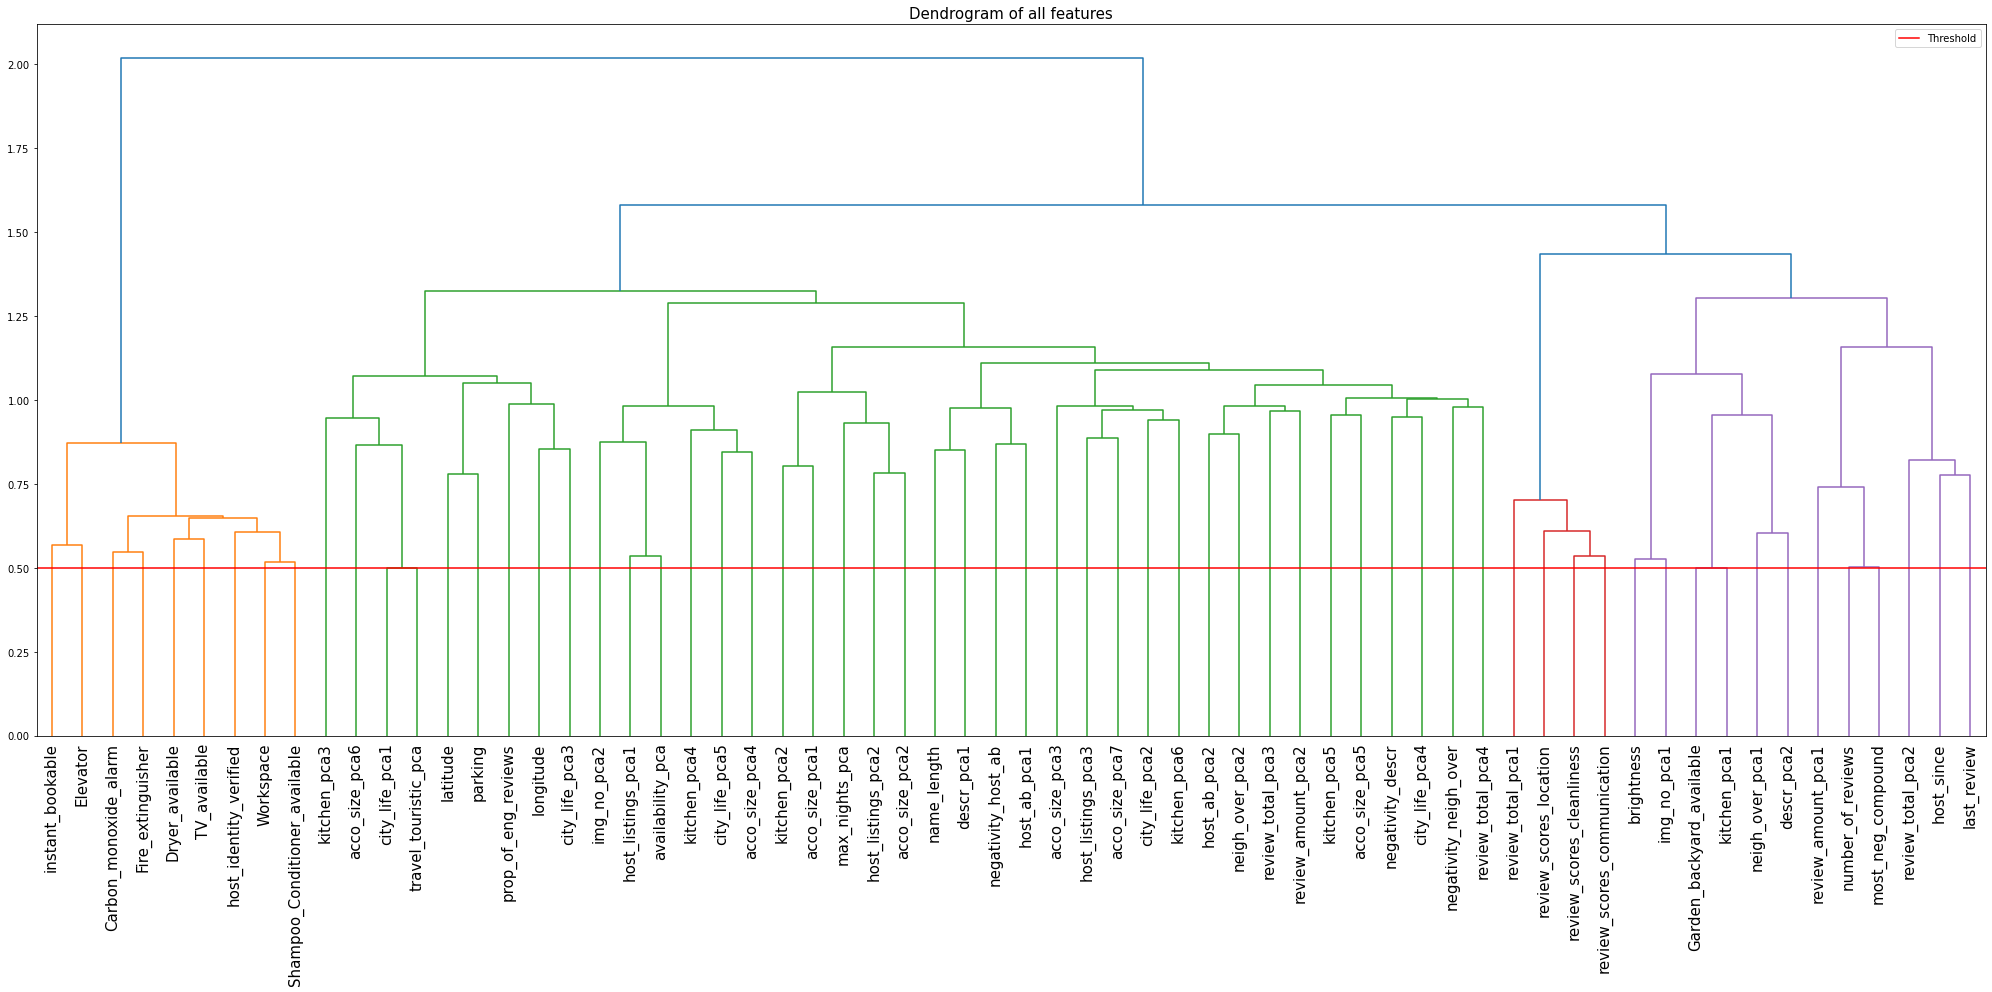

In [158]:
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(2000*px, 1000*px))
corr2 = C2
# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr2)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=all_col_compl, ax=ax, leaf_rotation=90, leaf_font_size=15
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax.set_title("Dendrogram of all features", fontsize = 15)
ax.axhline(0.5, color = "red", label = "Threshold")
ax.legend()
fig.tight_layout()
plt.show()

# XGBoost Baseline Model

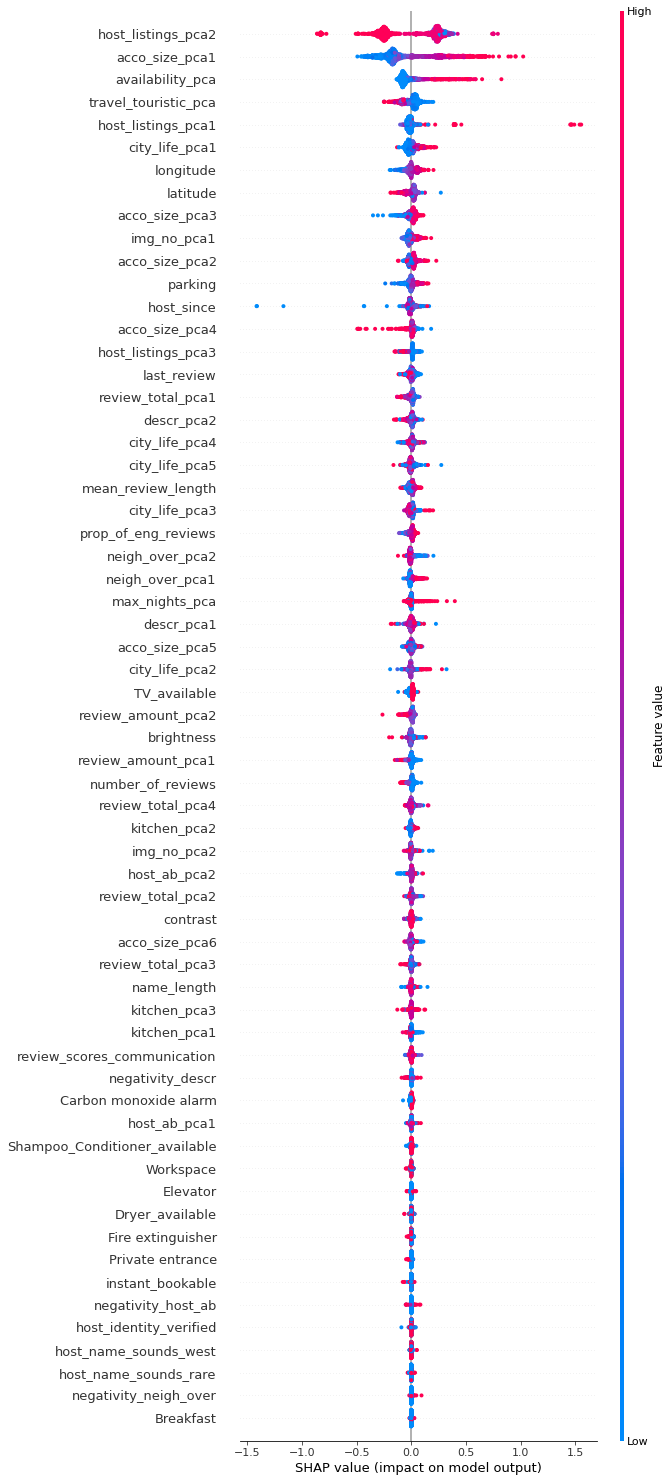

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state = 123, test_size = 0.2)

# train an XGBoost model
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.explainers.Tree(model)
shap_values = explainer(X_test)
#shap.summary_plot(shap_values, X_test, )
# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[2])
shap.plots.beeswarm(shap_values, max_display = len(X_train.columns))

In [314]:
model.score(X_test, y_test)

0.625260842702686

In [315]:
vals= np.abs(shap_values.values).mean(0)

In [316]:
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
sorted_idx_shap = feature_importance.index.values

In [317]:
# Standardize SHAP
std_vals_shap = ((vals - np.mean(vals))/np.std(vals))[sorted_idx_shap]

In [318]:
perm_importance = permutation_importance(model, X_test, y_test)

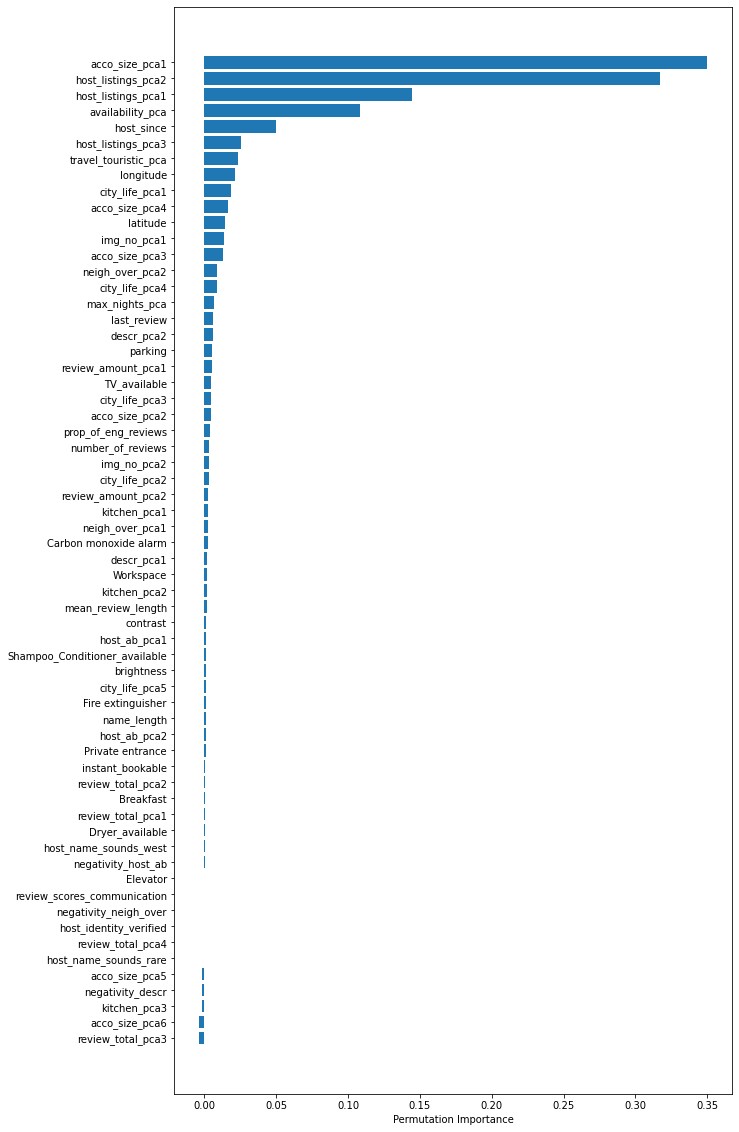

In [319]:
sorted_idx_pi = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(1,1,figsize = (10,20))
ax.barh(X_train.columns[sorted_idx_pi], perm_importance.importances_mean[sorted_idx_pi])
ax.set_xlabel("Permutation Importance")

# Standardize Permutation Importance
std_vals_pi = ((perm_importance["importances_mean"] - np.mean(perm_importance["importances_mean"]))/np.std(perm_importance["importances_mean"]))[sorted_idx_pi]

In [320]:
feat_index = pd.DataFrame({"Features": X_train.columns, "Feature_Index": np.arange(len(X_train.columns))})

In [321]:
feat_index
rank_shap = []
rank_pi = []
std_val_shap = []
std_val_pi = []
for i in feat_index["Feature_Index"]:
    std_val_shap.append(np.squeeze(std_vals_shap[np.where(sorted_idx_shap == i)[0].astype(int)]))
    std_val_pi.append(np.squeeze(std_vals_pi[np.where(sorted_idx_pi == i)[0].astype(int)]))


feat_index["Val_shap"] = std_val_shap
feat_index["Val_pi"] = std_val_pi
feat_index["Mean_Val"] = feat_index[["Val_shap", "Val_pi"]].mean(axis = 1)

In [322]:
feat_index = feat_index.sort_values("Mean_Val", ascending = False)
feat_index

,Features,Feature_Index,Val_shap,Val_pi,Mean_Val
38,host_listings_pca2,38,5.4723153,4.805300799291582,5.138808
56,acco_size_pca1,56,4.8673253,5.332675966632246,5.100001
40,availability_pca,40,1.6052152,1.438451023594415,1.521833
37,host_listings_pca1,37,0.35498732,2.0171919382353445,1.186090
33,travel_touristic_pca,33,0.60977274,0.06567266816086975,0.337723
...,...,...,...,...,...
11,host_name_sounds_west,11,-0.4938768,-0.3094674339390466,-0.401672
0,host_identity_verified,0,-0.48520276,-0.31952479543512974,-0.402364
2,Breakfast,2,-0.5075514,-0.30405525620819995,-0.405803
12,host_name_sounds_rare,12,-0.5010441,-0.3233783483663703,-0.412211


In [54]:
#final_variables = feat_index[feat_index["Mean_Val"] > -0.3]["Features"].values

In [56]:
# final_listings = X_train.filter(final_variables)
# final_listings.to_csv("Final_listings.csv", index = False)

# Final Selection

## Random Forest Model

In [37]:
len(price_y) == len(listings)

True

In [38]:
# train full random forest
forest = RandomForestRegressor(1000, random_state = 123, max_features = "sqrt", max_depth = 7)
X_train, X_test, y_train, y_test = train_test_split(listings_compl, price_y, random_state = 123, test_size = 0.2)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.5624546697520705

## Naive approach with training data

Compute the importance of each feature which is basically the average contribution to the decrease in impurity/MSE. Let's also consider the standard deviation of this contribution.

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=listings_compl.columns)

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_57159/1908474449.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


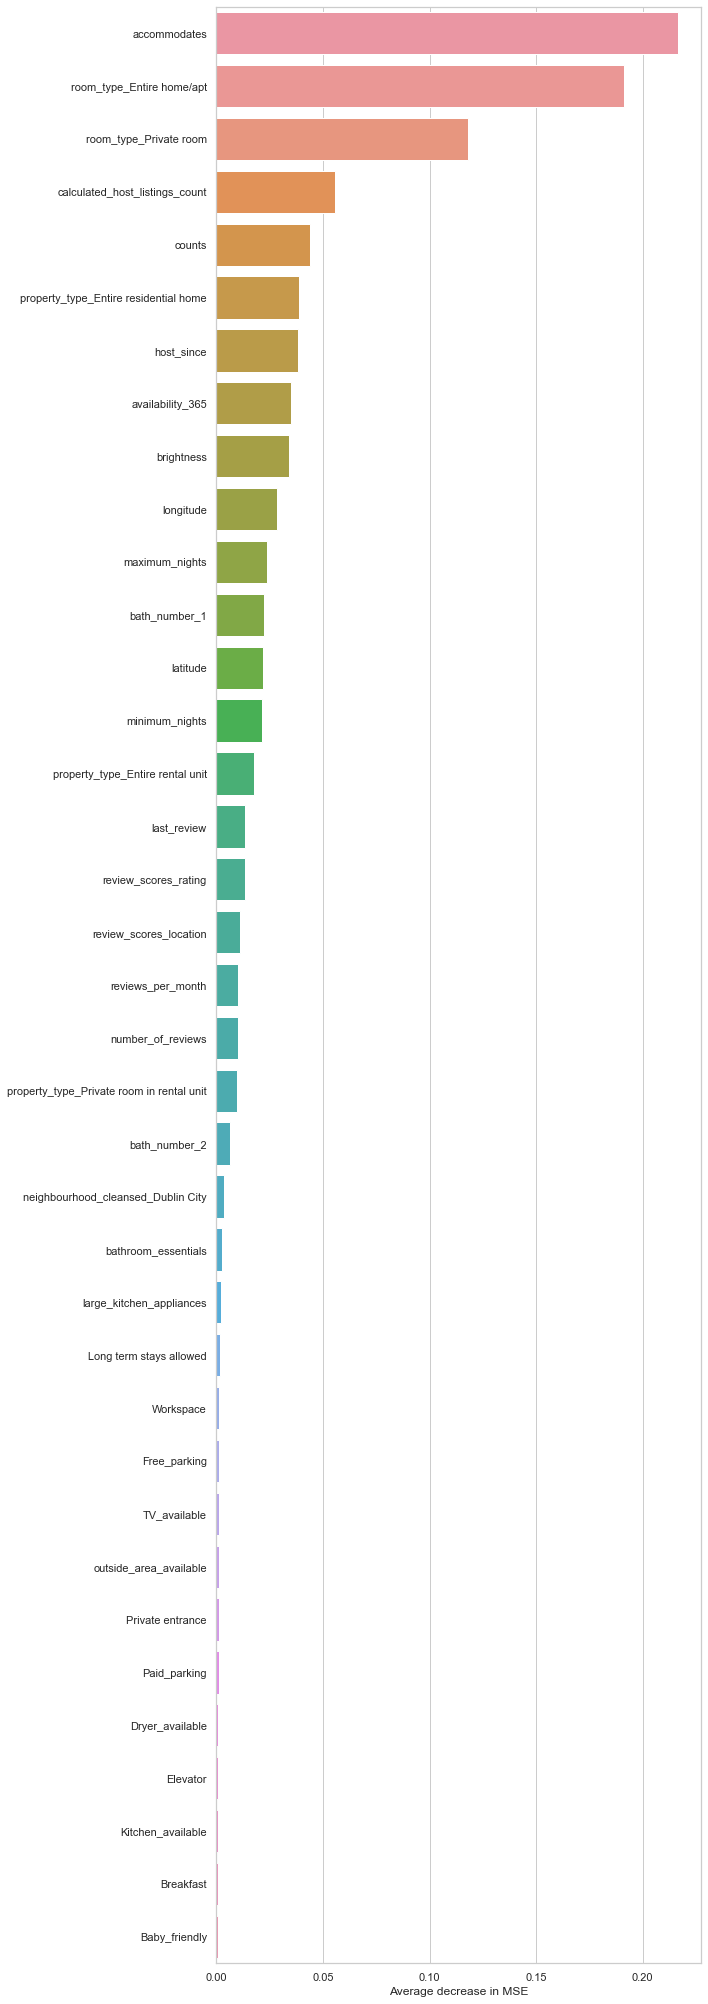

In [36]:
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Average decrease in MSE")
fig.tight_layout()
fig.show()

## Permutation

In [37]:
n_repeats = 10

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_57159/2623107921.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


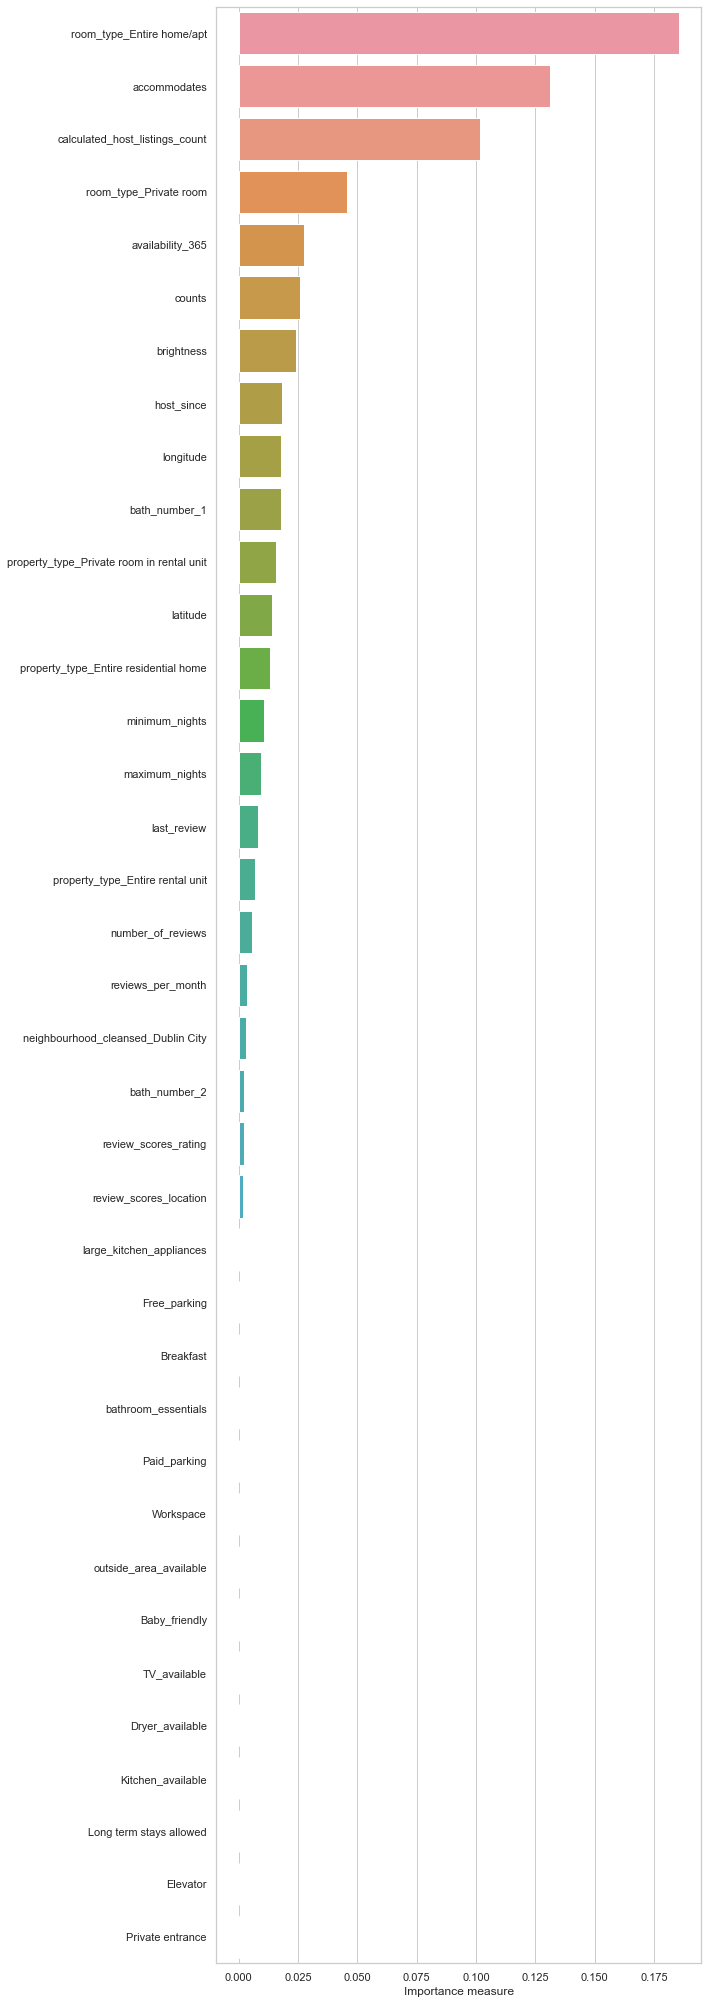

In [38]:
result = permutation_importance(forest, X_test, y_test, n_repeats = n_repeats, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = forest_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.4243019480272783

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_57159/2182281270.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


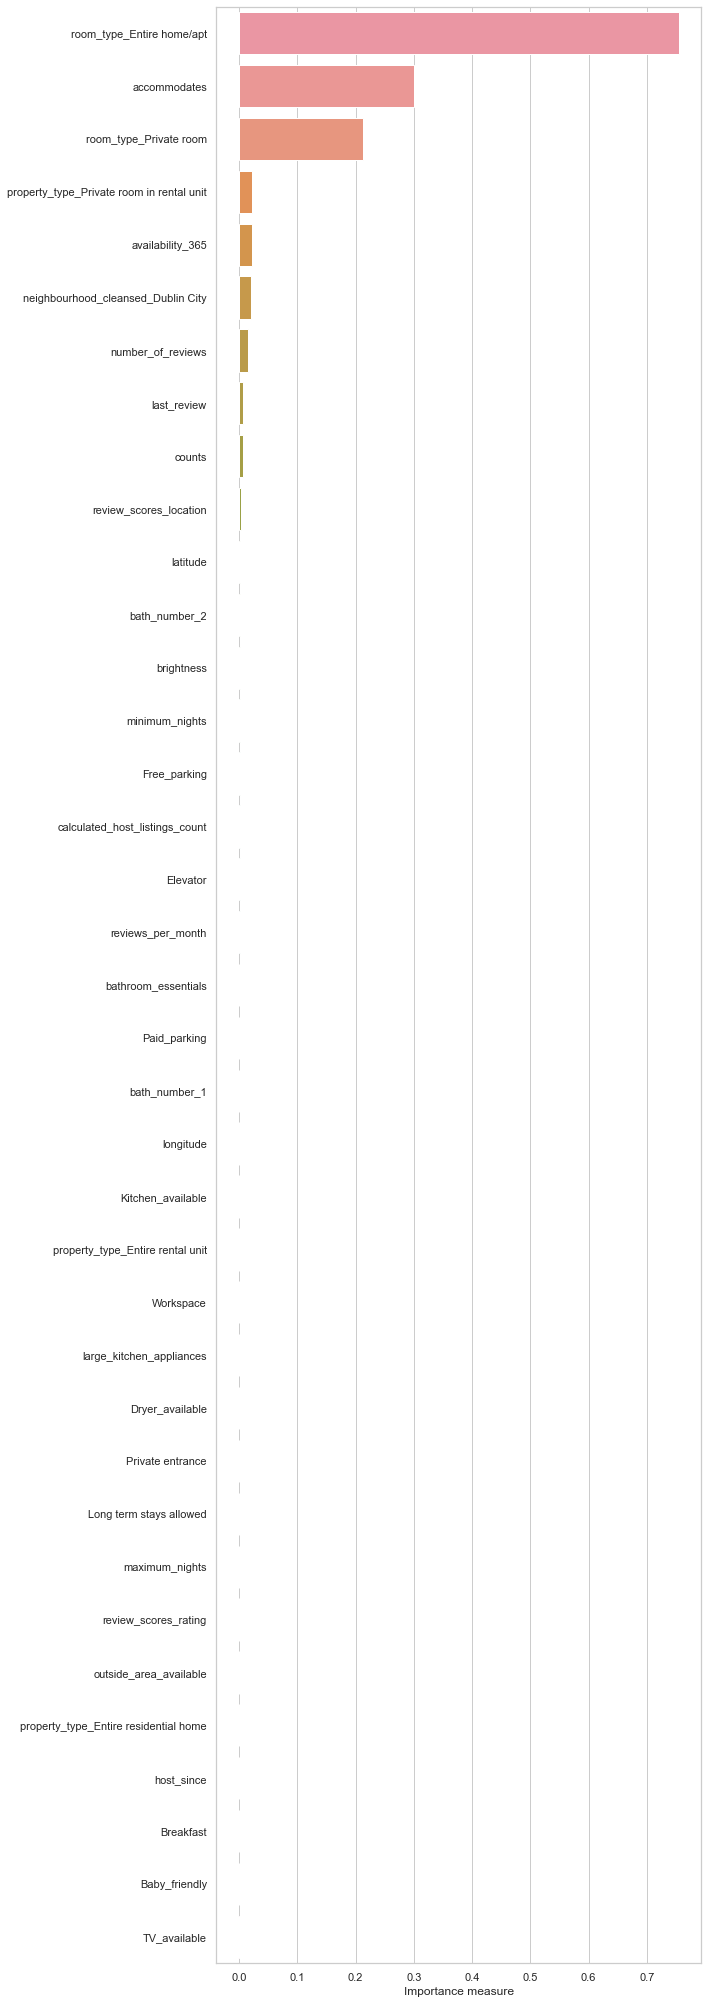

In [40]:
result = permutation_importance(reg, X_test, y_test, n_repeats=n_repeats, random_state=42)
lm_importances = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = lm_importances.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

## Boosting

In [330]:
params = {
    "n_estimators": 300,
    "max_depth": 3,
    "min_samples_split": 15,
    "learning_rate": 0.1,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.6502165612964628

In [331]:
result = permutation_importance(reg, X_test, y_test, n_repeats=100, random_state=42, scoring = "r2")
boost_feature_importance = pd.Series(result.importances_mean, index=listings_compl.columns)
# sort the features by their importance
plot_data = boost_feature_importance.sort_values(ascending=False)

# plotting
sn.set_theme(style = "whitegrid")
fig, ax = plt.subplots(figsize = (10,28))
sn.barplot(x=plot_data.values, y=plot_data.index)
ax.set_xlabel("Importance measure")
fig.tight_layout()
fig.show()

ValueError: Length of values (24) does not match length of index (42)

In [43]:
importances = pd.DataFrame({"Forest": forest_importances, "Linear Regression": lm_importances, "Boosting": boost_feature_importance})

In [44]:
importances

,Forest,Linear Regression,Boosting
Breakfast,0.000214,-0.000632,-0.000378
Elevator,-0.000014,0.000954,-0.000045
Long term stays allowed,0.000002,0.000034,-0.000104
Private entrance,-0.000064,0.000123,-0.000058
Workspace,0.000097,0.000387,-0.000011
Dryer_available,0.000016,0.000157,-0.000007
Kitchen_available,0.000011,0.000508,0.000200
neighbourhood_cleansed_Dublin City,0.003224,0.020600,0.003578
property_type_Entire rental unit,0.006932,0.000398,0.000098
property_type_Entire residential home,0.013301,-0.000250,0.036090


In [45]:
importances.mean(axis = 1).sort_values(ascending=False)

room_type_Entire home/apt                    4.113504e-01
accommodates                                 2.580741e-01
calculated_host_listings_count               1.554032e-01
room_type_Private room                       9.435167e-02
availability_365                             5.506260e-02
latitude                                     1.956704e-02
property_type_Entire residential home        1.638061e-02
counts                                       1.504086e-02
longitude                                    1.375921e-02
property_type_Private room in rental unit    1.318567e-02
host_since                                   1.290592e-02
minimum_nights                               1.123159e-02
number_of_reviews                            1.113015e-02
brightness                                   1.080247e-02
neighbourhood_cleansed_Dublin City           9.133709e-03
last_review                                  8.677700e-03
bath_number_1                                6.785462e-03
review_scores_

In [37]:
model.score(X_test, y_test)

0.6583689569425414

In [49]:
import tensorflow as tf
from tensorflow import keras

Init Plugin
Init Graph Optimizer
Init Kernel


In [47]:
X_test.shape

(1368, 37)

In [71]:
num_features = X_train.shape[1]

inputs_feat = keras.layers.Input(shape = num_features)
x = keras.layers.Dense(5000, activation = "relu")(inputs_feat)
x = keras.layers.Dense(1000, activation = "relu")(inputs_feat)

out = keras.layers.Dense(1)(x)
model = keras.Model(inputs_feat, out)

In [72]:
model.compile("adam", "mse")
model.fit(X_train, y_train, batch_size = 32, epochs = 20)

Epoch 1/20
 19/171 [==>...........................] - ETA: 1s - loss: 6.6631 

2022-01-09 19:41:09.902282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 1s 6ms/step - loss: 1.3507
Epoch 2/20
171/171 [==============================] - 1s 6ms/step - loss: 0.3936
Epoch 3/20
171/171 [==============================] - 1s 6ms/step - loss: 0.3286
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2982
Epoch 5/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2758
Epoch 6/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2657
Epoch 7/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2533
Epoch 8/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2779
Epoch 9/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2252
Epoch 10/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2219
Epoch 11/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2091
Epoch 12/20
171/171 [==============================] - 1s 6ms/step - loss: 0.2009
Epoch 13/20
171/171 [===============

In [67]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  return r2

Parameter XGBoost
- eta (0.01-0.2)
- gamma - minimum loss reduction for split (0, infty)
- max depth - Tiefe des Baums, je tiefer desto eher overfitting (3-10)
- min_child_weight: Summe der Gewichte in den Leaves. Regelt overfitting (0, infty)
- subsample - Anteil der Beobachtungen den Tree zufällig zugewiesen bekommt. Regel overfitting (0.5-1)
- lambda - l2 Regularisierung der Gewichte